# **Import**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil

# **Enable GPU**

In [12]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  # Currently, memory growth needs to be the same across GPUs
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
# Define paths and general Info
train_path = "../VegetableImages/train"
validation_path = "../VegetableImages/validation"
test_path = "../VegetableImages/test"

image_categories = os.listdir('../VegetableImages/train')

def countFilesInDir(dirPath):
    count = 0
    for base, dirs, files in os.walk(dirPath):
        for file in files:
            count = count + 1
    return count


print("Number of images in training set: ", countFilesInDir(train_path))
print("Number of images in validation set: ", countFilesInDir(validation_path))
print("Number of images in testing set: ", countFilesInDir(test_path))

Number of images in training set:  15000
Number of images in validation set:  3000
Number of images in testing set:  3000


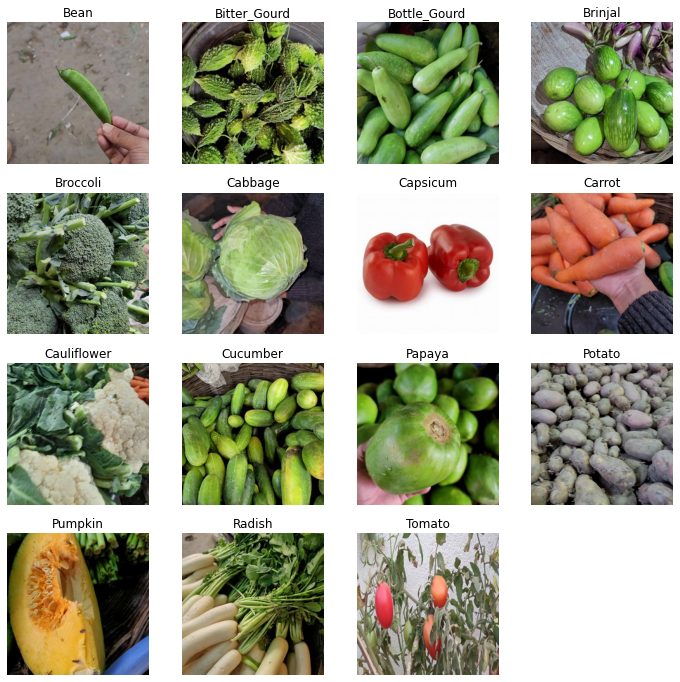

In [4]:
# Let's plot a few images

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)

# **Split Dataset**

In [5]:
## Important parameters
imageSize = 150
batchSize = 64
seedNum = 42
classificationMode = 'categorical'

In [20]:
# Creating Image Data Generator for train, validation and test set

normalizer = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data

# 1. Train Set
trainSet = normalizer.flow_from_directory(train_path,
                                        target_size=(imageSize, imageSize),
                                        batch_size=batchSize, 
                                        seed=seedNum,
                                        class_mode=classificationMode)

# 2. Validation Set
valSet = normalizer.flow_from_directory(validation_path,
                                    target_size=(imageSize, imageSize),
                                    batch_size=batchSize, 
                                    seed=seedNum,
                                    class_mode=classificationMode)

# 3. Test Set
testSet = normalizer.flow_from_directory(test_path,
                                        target_size=(imageSize, imageSize),
                                        batch_size=batchSize, 
                                        seed=seedNum,
                                        class_mode=classificationMode)


# Print the class encodings done by the generators
class_map = dict([(v, k) for k, v in trainSet.class_indices.items()])
print()
print("Dataset classes:")
print(class_map)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.

Dataset classes:
{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


# **Build & Compile model**

In [14]:
# Build a sequential CNN model

model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[imageSize, imageSize, 3]))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dense(15, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 128)     

In [15]:
# Compile and fit the model

# Custom learning_rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

hist = model.fit(trainSet,
                 epochs=20, 
                 verbose=1, 
                 validation_data=valSet, 
                 steps_per_epoch = countFilesInDir(train_path)//batchSize, 
                 validation_steps = countFilesInDir(validation_path)//batchSize)


# Predict the accuracy for the test set
scores = model.evaluate(testSet)
print()
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
234/234 [==============================] - 25s 105ms/step - loss: 1.5809 - accuracy: 0.4678 - val_loss: 0.8507 - val_accuracy: 0.7181
Epoch 2/20
234/234 [==============================] - 26s 112ms/step - loss: 0.6902 - accuracy: 0.7735 - val_loss: 0.4779 - val_accuracy: 0.8465
Epoch 3/20
234/234 [==============================] - 24s 103ms/step - loss: 0.4396 - accuracy: 0.8574 - val_loss: 0.3748 - val_accuracy: 0.8859
Epoch 4/20
234/234 [==============================] - 24s 103ms/step - loss: 0.3040 - accuracy: 0.9039 - val_loss: 0.2488 - val_accuracy: 0.9263
Epoch 5/20
234/234 [==============================] - 21s 91ms/step - loss: 0.2172 - accuracy: 0.9308 - val_loss: 0.1907 - val_accuracy: 0.9463
Epoch 6/20
234/234 [==============================] - 22s 95ms/step - loss: 0.1633 - accuracy: 0.9494 - val_loss: 0.1763 - val_accuracy: 0.9531
Epoch 7/20
234/234 [==============================] - 24s 100ms/step - loss: 0.1140 - accuracy: 0.9666 - val_loss: 0.1809 - val_accu

# **Plots and tests**

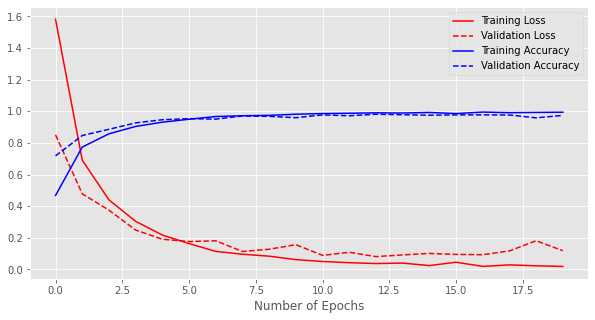

In [16]:
# Plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

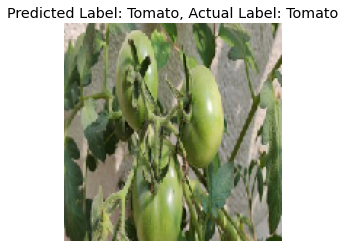

In [17]:
# Testing the Model

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(imageSize, imageSize))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    
    # 3. Plot image
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
test_image_path = '../VegetableImages/test/Tomato/1008.jpg'
generate_predictions(test_image_path, actual_label='Tomato')

# **Saving model**

In [19]:
model.save("../latestModelAfterEnhance.h5")

In [ ]:
# To free GPU Memory
# from numba import cuda
# cuda.select_device(0)
# cuda.close()